In [ ]:
'0907'

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

class Model(nn.Module):

    def set_data(
        self, 
        x, 
        y, 
        split_options = dict(
            test_size= 0.2, 
            random_state = 42
        ),
        tensors_type_x = torch.float32,
        tensors_type_y = torch.float32,
    ):
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(x, y, **split_options)

        # to tensor
        self.x_train = torch.tensor(self.x_train, dtype=tensors_type_x)
        self.x_test = torch.tensor(self.x_test, dtype=tensors_type_x)
        self.y_train = torch.tensor(self.y_train, dtype=tensors_type_y)
        self.y_test = torch.tensor(self.y_test, dtype=tensors_type_y)


    def optimize_params(
        self, 
        criterion = nn.MSELoss,
        optimizer = optim.Adam,
        optimizer_options = dict(lr = 0.001), 
        num_epochs = 50,
        batch_size = 32,
        dataloader_options = dict(shuffle = True)
    ):
        criterion = criterion()
        optimizer = optimizer(
            self.parameters(), 
            **optimizer_options
        )

        # dataloader
        loader = DataLoader(
            TensorDataset(self.x_train, self.y_train), 
            batch_size=batch_size, 
            **dataloader_options
        )

        for epoch in range(num_epochs):
            for batch_idx, (data, target) in enumerate(loader):
                optimizer.zero_grad()
                outputs = self(data)
                loss = criterion(outputs, target)
                loss.backward()
                optimizer.step()

            if (epoch+1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


    def validate(
        self
    ):
        self.eval()
        with torch.no_grad():
            test_outputs = self(self.x_test)
            _, predicted = torch.max(test_outputs, 1)
            accuracy = (predicted == self.y_test).sum().item() / self.y_test.size(0)
            print(f'Accuracy on test data: {accuracy*100:.2f}%')

In [4]:
from sklearn.datasets import load_iris

# 1. Load and preprocess the dataset
iris = load_iris()
x = iris.data
y = iris.target


# Define the model
class IrisNet(Model):
    def __init__(self):
        super(IrisNet, self).__init__()
        self.fc1 = nn.Linear(4, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = IrisNet()

# set data
model.set_data(x, y)

# Train the model
model.optimize_params(num_epochs=100)

# Evaluate the model
model.validate()



/usr/lib/python3/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/lib/python3/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 0.7734
Epoch [20/100], Loss: 0.7569
Epoch [30/100], Loss: 0.5145
Epoch [40/100], Loss: 0.7587
Epoch [50/100], Loss: 0.7709
Epoch [60/100], Loss: 0.7182
Epoch [70/100], Loss: 0.7228
Epoch [80/100], Loss: 0.7600
Epoch [90/100], Loss: 0.5916
Epoch [100/100], Loss: 0.7475
Accuracy on test data: 33.33%


In [19]:
import json
import matplotlib.pyplot as plt

In [62]:
class keep():
    def __init__(
        self, 
        last = True, 
        best = False,
        history = False, 
    ):
        if not any([last, best, history]):
            raise ValueError("At least one of 'last', 'best', 'history' must be True")

        self.last = last
        self.best = best
        self.history = history

    def __repr__(self):
        return str(self.__dict__)

    
class results_item():
    def __init__(self, what_to_keep = keep()):  

        self.what_to_keep = what_to_keep      

        if what_to_keep.last:
            self.last = None
        if what_to_keep.best:
            self.best = None
        if what_to_keep.history:
            self.history = []

    def __call__(self):
        if self.what_to_keep.last:
            return self.last
        if self.what_to_keep.best:
            return self.best
        if self.what_to_keep.history:
            return self.history

    def __repr__(self):
        return str({k: v for k, v in self.__dict__.items() if k != 'what_to_keep'})
    
    def __iter__(self):
        return iter({k: v for k, v in self.__dict__.items()  if k != 'what_to_keep'}.items())

    def update(self, value, update_best=None):
        best_changed = False
        if self.what_to_keep.last:
            self.last = value

        if self.what_to_keep.best:
            if update_best is None:
                if self.best is None or self.best > value:         
                    best_changed = True
                    self.best = value
            elif update_best:
                best_changed = True
                self.best = value

        if self.what_to_keep.history:
            self.history.append(value)    
        return best_changed

    def __getitem__(self, key):
        return getattr(self, key)

        

class Results():
    def __init__(
        self, 
        **attributes
    ):
        """
            Example:
            results = Results(
                loss = keep(last=True, best=True, history=True),
                accuracy = keep(last=True, best=True, history=True),
            )
        """
        for attribute, what_to_keep in attributes.items():
            # check if options is a keep object
            if not isinstance(what_to_keep, keep):
                raise ValueError(f"Value for '{attribute}' must be an object of class 'keep'")

            # create attribute
            setattr(self, attribute, results_item(what_to_keep))

    def update(self, update_leader:str=None, **attributes):

        # check if all attributes are available
        for attribute in attributes.keys():
            attribute = getattr(self, attribute, False)
            if not attribute:
                raise ValueError(f"Attribute '{attribute}' not found. Attributes available: {list(self.__dict__.keys())}")

        # update attributes
        if update_leader is None: # if there is no leader, update all attributes
            for attribute, value in attributes.items():
                attribute = getattr(self, attribute, False)
                attribute.update(value)
                
        else: # if there is a leader, update first the leader and then the rest (passing if the leader updated the best)
            if update_leader not in attributes.keys():
                raise ValueError(f"Attribute '{update_leader}' not found. It should be one of {list(attributes.keys())}")

            best_changed = getattr(self, update_leader).update(attributes.pop(update_leader))
            for attribute, value in attributes.items():
                getattr(self, attribute).update(value, update_best=best_changed)

    def __call__(self):
        return self.__dict__

    def __repr__(self):
        return str(self.__dict__)

    def __getitem__(self, key):
        return getattr(self, key)
        
    def __iter__(self):
        return iter({k: dict(v) for k, v in self.__dict__.items()}.items())

    def dump(self, path, metadata = {}):
        # union of metadata and results
        dict_to_dump = {'metadata': metadata, 'results': dict(self)}
        with open(path, 'w') as f:
            json.dump(dict_to_dump, f)

    @classmethod
    def load(cls, path):
        with open(path, 'r') as f:
            dict_to_load = json.load(f)['results']

        results_obj = cls(**{k: keep('last' in v, 'best' in v, 'history' in v) for k, v in dict_to_load.items()})
        for att, dic in dict_to_load.items():
            for k, v in dic.items():
                setattr(getattr(results_obj, att), k, v)
        
        return results_obj

    def plot(self, y_attribute, x_attribute=None, title=None, xlabel=None, ylabel=None):

        
        data_y = getattr(getattr(self, y_attribute), 'history', False)
        if data_y is False: raise ValueError(f"Attribute '{y_attribute}' does not have history")

        if x_attribute is None:
            plt.plot(data_y)
        else:
            data_x = getattr(getattr(self, x_attribute), 'history', False)
            if data_x is False: raise ValueError(f"Attribute '{x_attribute}' does not have history")

            plt.plot(data_x, data_y)
            
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.show()

In [63]:
results = Results(
    loss_epoch = keep(last = True,  best = True, history = True ),
    n_epoch    = keep(last = False, best = False, history = True),
    state      = keep(last = False, best = True, history = False),
)



In [64]:
results.update(
    update_leader='loss_epoch',
    loss_epoch=2,
    state='a',
    n_epoch=1,
)
results.update(
    update_leader='loss_epoch',
    loss_epoch=2,
    state = 'b',
    n_epoch=3,
)
results.update(
    update_leader='loss_epoch',
    state='c',
    loss_epoch=4,
    n_epoch=5,
)
results.update(
    update_leader='loss_epoch',
    state='K',
    loss_epoch=0.3,
    n_epoch=6,
)
results.update(
    update_leader='loss_epoch',
    loss_epoch=5,
    state='f',
    n_epoch=7,
)

In [65]:
results.dump('results.json')

In [66]:
results

{'loss_epoch': {'last': 5, 'best': 0.3, 'history': [2, 2, 4, 0.3, 5]}, 'n_epoch': {'history': [1, 3, 5, 6, 7]}, 'state': {'best': 'K'}}

In [67]:
results_2 = Results.load('results.json')

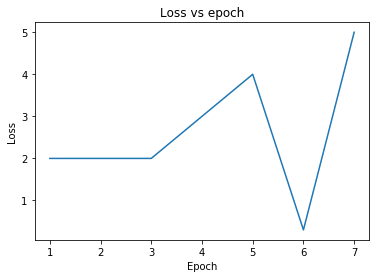

In [70]:
results_2.plot('loss_epoch', 'n_epoch', title='Loss vs epoch', xlabel='Epoch', ylabel='Loss')